#Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/zkwgkjkjn9-2.zip

In [ ]:
!cp ./drive/MyDrive/MultimodalGasData.zip MultimodalGasData.zip

In [ ]:
!unzip MultimodalGasData.zip

Archive:  MultimodalGasData.zip
  inflating: zkwgkjkjn9-2/Gas Sensors Measurements/Gas_Sensors_Measurements.csv  
  inflating: zkwgkjkjn9-2/Thermal Camera Images/Mixture.zip  
  inflating: zkwgkjkjn9-2/Thermal Camera Images/NoGas.zip  
  inflating: zkwgkjkjn9-2/Thermal Camera Images/Perfume.zip  
  inflating: zkwgkjkjn9-2/Thermal Camera Images/Smoke.zip  
  inflating: zkwgkjkjn9-2/Thermal Camera Images/Sample Thermal Camera Images/Mixture/10_Mixture.png  
  inflating: zkwgkjkjn9-2/Thermal Camera Images/Sample Thermal Camera Images/Mixture/18_Mixture.png  
  inflating: zkwgkjkjn9-2/Thermal Camera Images/Sample Thermal Camera Images/Mixture/11_Mixture.png  
  inflating: zkwgkjkjn9-2/Thermal Camera Images/Sample Thermal Camera Images/Mixture/13_Mixture.png  
  inflating: zkwgkjkjn9-2/Thermal Camera Images/Sample Thermal Camera Images/Mixture/14_Mixture.png  
  inflating: zkwgkjkjn9-2/Thermal Camera Images/Sample Thermal Camera Images/Mixture/16_Mixture.png  
  inflating: zkwgkjkjn9-2/Ther

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.utils import plot_model

#Classifications

#Preprocess

In [ ]:
dataset = 'zkwgkjkjn9-2/Gas Sensors Measurements/Gas_Sensors_Measurements.csv'
df = pd.read_csv(dataset)
df.head()

,Serial Number,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas,Corresponding Image Name
0,0,555,515,377,338,666,451,416,NoGas,0_NoGas
1,1,555,516,377,339,666,451,416,NoGas,1_NoGas
2,2,556,517,376,337,666,451,416,NoGas,2_NoGas
3,3,556,516,376,336,665,451,416,NoGas,3_NoGas
4,4,556,516,376,337,665,451,416,NoGas,4_NoGas


In [ ]:
df = df.drop(['Serial Number', 'Corresponding Image Name'], axis=1)
print(df.info())
print('*********************************************************')
print(df.nunique())
print('*********************************************************')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MQ2     6400 non-null   int64 
 1   MQ3     6400 non-null   int64 
 2   MQ5     6400 non-null   int64 
 3   MQ6     6400 non-null   int64 
 4   MQ7     6400 non-null   int64 
 5   MQ8     6400 non-null   int64 
 6   MQ135   6400 non-null   int64 
 7   Gas     6400 non-null   object
dtypes: int64(7), object(1)
memory usage: 400.1+ KB
None
*********************************************************
MQ2      322
MQ3      152
MQ5      263
MQ6      204
MQ7      351
MQ8      557
MQ135    314
Gas        4
dtype: int64
*********************************************************
               MQ2          MQ3          MQ5          MQ6          MQ7  \
count  6400.000000  6400.000000  6400.000000  6400.000000  6400.000000   
mean    677.593438   462.024688   404.579063   399.758750   565.952031   
std      92.913955    

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

MQ2      0
MQ3      0
MQ5      0
MQ6      0
MQ7      0
MQ8      0
MQ135    0
Gas      0
dtype: int64


In [ ]:
X = df.drop(['Gas'], axis=1)
y = df['Gas']
print(X.shape, y.shape)

(6400, 7) (6400,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
labels = {0: 'Mixture', 1: 'No Gas', 2: 'Perfume', 3: 'Smoke'}

In [ ]:
def plot_results(model, param_grid, model_name):
    param_values = [str(val) for val in list(param_grid.values())[0]]
    mean_scores = model.cv_results_['mean_test_score']

    plt.figure(figsize=(8, 6))
    plt.plot(param_values, mean_scores, marker='o')
    plt.title(f"{model_name} - Grid Search Results")
    plt.xlabel(list(param_grid.keys())[0])
    plt.ylabel('Mean Test Score')
    plt.grid(True)
    plt.show()

##Dicision Tree(DT)

In [ ]:
DC = DecisionTreeClassifier(criterion='gini', random_state=42)

DC.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred_tree = DC.predict(X_test)
y_pred_tree.shape

(1280,)

In [ ]:
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Decision Tree Accuracy: {accuracy_tree:.2f}")
f1_score_tree = f1_score(y_test, y_pred_tree, average='macro')
print(f"Decision Tree f1_score: {f1_score_tree:.2f}")

Decision Tree Accuracy: 0.96
Decision Tree f1_score: 0.96


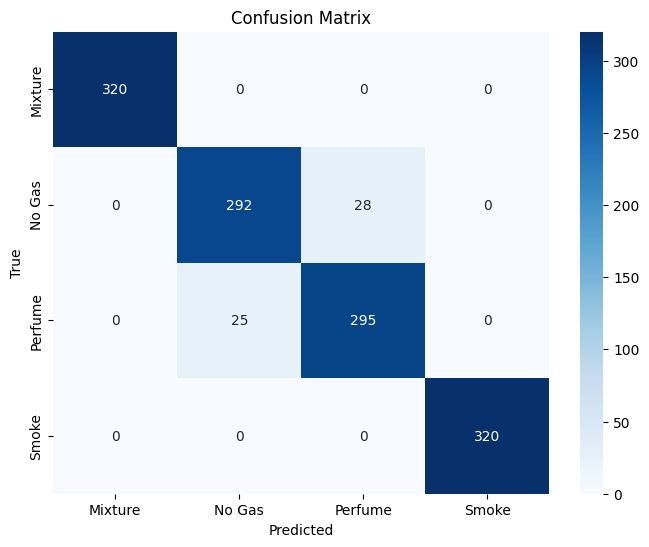

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(labels.values()),
            yticklabels=list(labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
tree_param_grid = {'criterion': ["gini", "entropy", "log_loss"]}
tree_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_param_grid)
tree_grid_search.fit(X_train, y_train)

print("Decision Tree - Best parameters:", tree_grid_search.best_params_)

Decision Tree - Best parameters: {'criterion': 'entropy'}


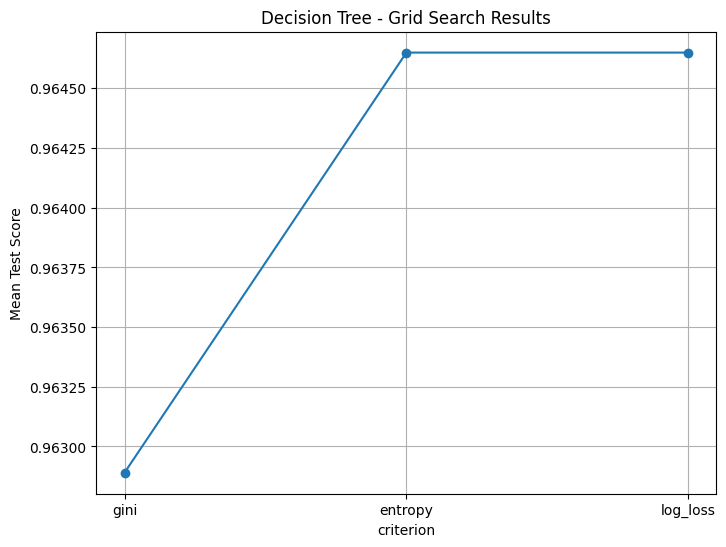

In [ ]:
plot_results(tree_grid_search, tree_param_grid, "Decision Tree")

##KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
y_pred_knn = knn.predict(X_test)

In [ ]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.2f}")

f1_score_knn = f1_score(y_test, y_pred_knn, average='macro')
print(f"KNN f1_score: {f1_score_knn:.2f}")

KNN Accuracy: 0.98
KNN f1_score: 0.98


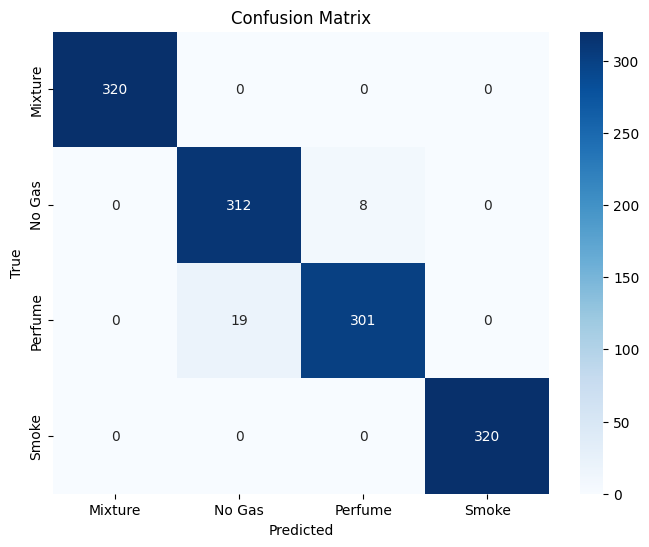

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(labels.values()),
            yticklabels=list(labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
knn_param_grid = {'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
knn_grid_search = GridSearchCV(KNeighborsClassifier(n_neighbors=4), knn_param_grid)
knn_grid_search.fit(X_train, y_train)

print("K-Nearest Neighbors - Best parameters:", knn_grid_search.best_params_)

K-Nearest Neighbors - Best parameters: {'algorithm': 'auto'}


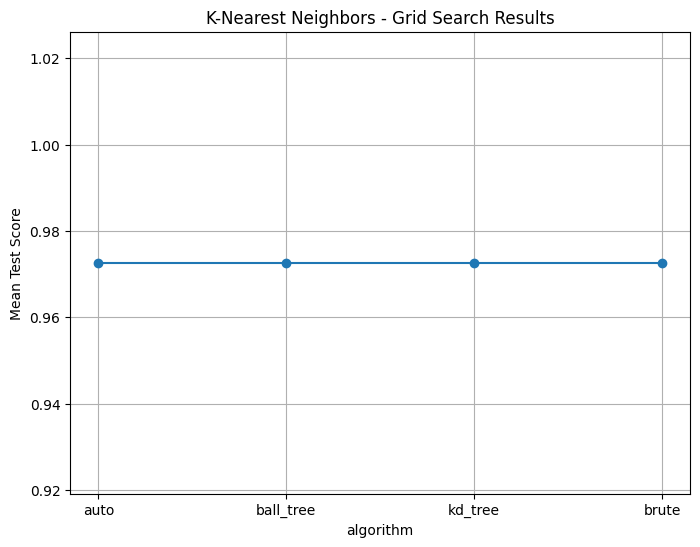

In [ ]:
plot_results(knn_grid_search, knn_param_grid, "K-Nearest Neighbors")

## MLP

In [ ]:
encoder = OneHotEncoder()

y_train_reshaped = y_train.values.reshape((-1,1))
y_train_onehot = encoder.fit_transform(y_train_reshaped).toarray()

y_test_reshaped = y_test.values.reshape((-1,1))
y_test_onehot = encoder.transform(y_test_reshaped).toarray()

In [ ]:
y_train_onehot.shape

(5120, 4)

In [ ]:
MLP = MLPClassifier(random_state=42)

In [ ]:
MLP.fit(X_train, y_train_onehot)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [ ]:
y_pred_mlp = MLP.predict_proba(X_test)

y_pred_mlp_classes = np.argmax(y_pred_mlp, axis=1)

accuracy_mlp = accuracy_score(np.argmax(y_test_onehot, axis=1), y_pred_mlp_classes)
print(f"Neural Network Accuracy: {accuracy_mlp:.2f}")

f1_mlp = f1_score(np.argmax(y_test_onehot, axis=1), y_pred_mlp_classes, average='macro')
print(f"Neural Network F1 Score: {f1_mlp:.2f}")

Neural Network Accuracy: 0.95
Neural Network F1 Score: 0.95


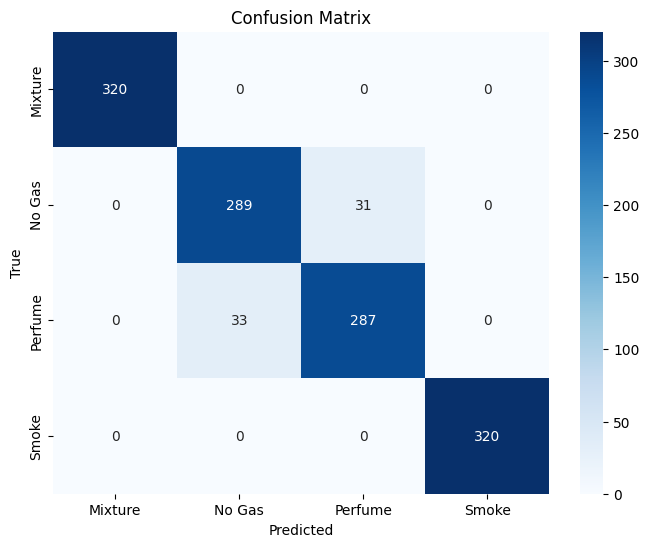

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test_onehot, axis=1), y_pred_mlp_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(labels.values()),
            yticklabels=list(labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
mlp_param_grid = {'hidden_layer_sizes': [(100,), (200,)]}
mlp_grid_search = GridSearchCV(MLPClassifier(random_state=42, max_iter=300), mlp_param_grid)
mlp_grid_search.fit(X_train, y_train_onehot)

print("Neural Network - Best parameters:", mlp_grid_search.best_params_)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Neural Network - Best parameters: {'hidden_layer_sizes': (200,)}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


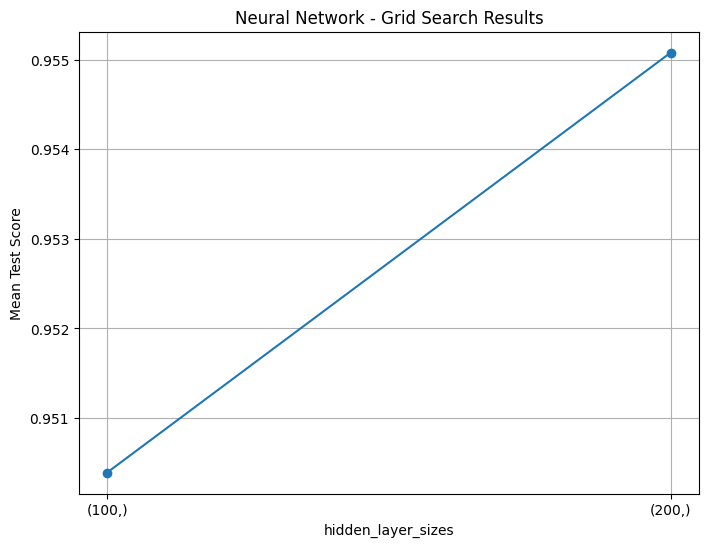

In [ ]:
plot_results(mlp_grid_search, mlp_param_grid, "Neural Network")

In [ ]:
mlp_param_grid = {'alpha': [0.0001, 0.001, 0.1]}
mlp_grid_search = GridSearchCV(MLPClassifier(random_state=42, max_iter=300), mlp_param_grid)
mlp_grid_search.fit(X_train, y_train_onehot)

print("Neural Network - Best parameters:", mlp_grid_search.best_params_)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Neural Network - Best parameters: {'alpha': 0.0001}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


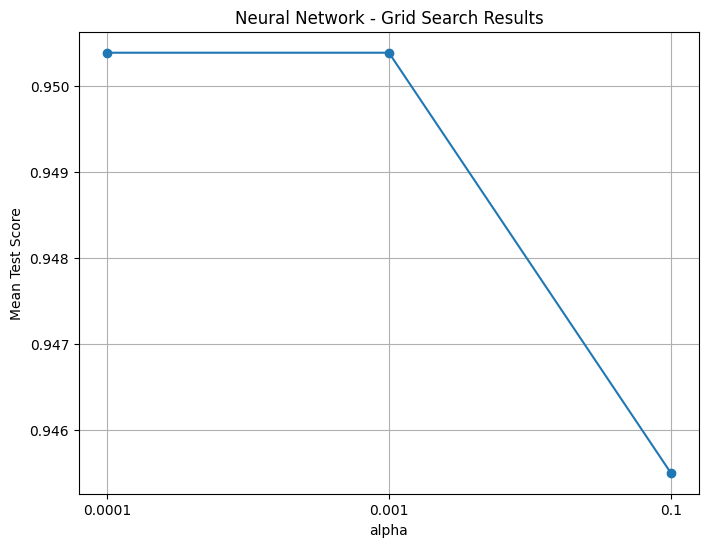

In [ ]:
plot_results(mlp_grid_search, mlp_param_grid, "Neural Network")

# Ensemble Learning

In [ ]:
classes = {'Mixture':0,'NoGas':1,'Perfume':2,'Smoke':3}

In [ ]:
y_train_encode = pd.get_dummies(y_train)
print(y_train_encode.shape)

y_test_encode = pd.get_dummies(y_test)
y_test_encode.shape

(5120, 4)


(1280, 4)

In [ ]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train_encode, test_size=0.2, random_state=42)

In [ ]:
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
mlp_model = MLPClassifier(max_iter=200, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=4)

dt_model.fit(X_train2, y_train2)
mlp_model.fit(X_train2, y_train2)
knn_model.fit(X_train2, y_train2)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


KNeighborsClassifier(n_neighbors=4)

In [ ]:
# Most Vote
dt_preds = dt_model.predict(X_val)
mlp_preds = mlp_model.predict(X_val)
knn_preds = knn_model.predict(X_val)

ensemble_preds = np.array([dt_preds, mlp_preds, knn_preds])
final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=ensemble_preds)

ensemble_accuracy = accuracy_score(y_val, final_preds)
print(f"Validation Ensemble Accuracy: {ensemble_accuracy}")

Validation Ensemble Accuracy: 0.962890625


In [ ]:
dt_preds = dt_model.predict(X_test)
mlp_preds = mlp_model.predict(X_test)
knn_preds = knn_model.predict(X_test)

ensemble_preds = np.array([dt_preds, mlp_preds, knn_preds])
final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=ensemble_preds)

ensemble_accuracy = accuracy_score(y_test_encode, final_preds)
print(f"Test Ensemble Accuracy: {ensemble_accuracy}")

Test Ensemble Accuracy: 0.96484375


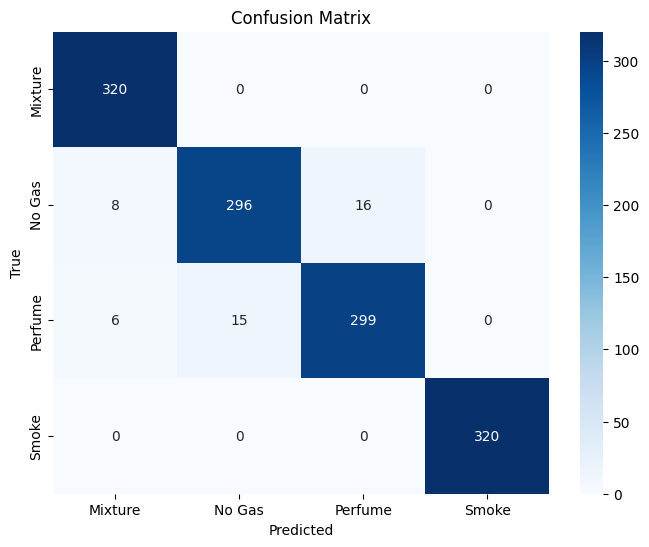

In [ ]:
conf_matrix = confusion_matrix((y_test_encode.idxmax(axis=1)).apply(lambda row: classes[row]), pd.DataFrame(final_preds).idxmax(axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(labels.values()),
            yticklabels=list(labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Regression or weighted mean
dt_preds = dt_model.predict(X_val)
mlp_preds = mlp_model.predict(X_val)
knn_preds = knn_model.predict(X_val)

meta_X = np.column_stack((dt_preds, mlp_preds, knn_preds))
meta_model = LinearRegression()
meta_model.fit(meta_X, y_val)

meta_preds = meta_model.predict(meta_X)

ensemble_accuracy = accuracy_score((y_val.idxmax(axis=1)).apply(lambda row: classes[row]), np.argmax(meta_preds, axis=1))
print(f"Validation Ensemble Accuracy: {ensemble_accuracy}")


Ensemble Accuracy: 0.970703125


In [ ]:
# Regression or weighted mean
dt_preds = dt_model.predict(X_test)
mlp_preds = mlp_model.predict(X_test)
knn_preds = knn_model.predict(X_test)

meta_X = np.column_stack((dt_preds, mlp_preds, knn_preds))
meta_model = LinearRegression()
meta_model.fit(meta_X, y_test_encode)

meta_preds = meta_model.predict(meta_X)

ensemble_accuracy = accuracy_score((y_test_encode.idxmax(axis=1)).apply(lambda row: classes[row]), np.argmax(meta_preds, axis=1))
print(f"Validation Ensemble Accuracy: {ensemble_accuracy}")


Validation Ensemble Accuracy: 0.971875


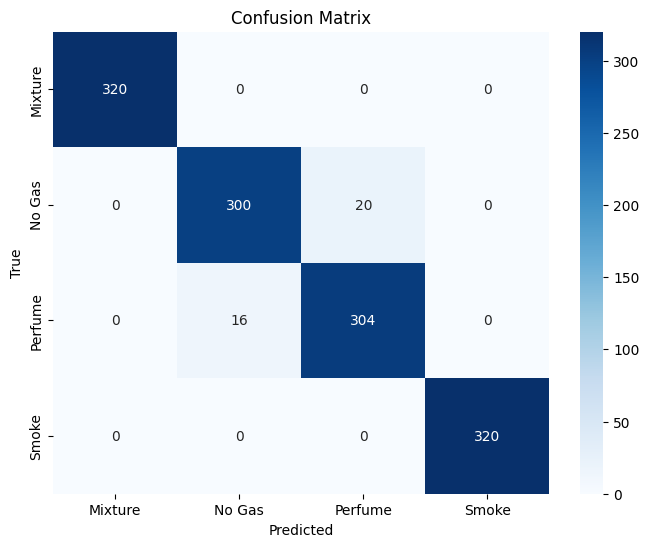

In [ ]:
conf_matrix = confusion_matrix((y_test_encode.idxmax(axis=1)).apply(lambda row: classes[row]), np.argmax(meta_preds, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(labels.values()),
            yticklabels=list(labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# RandomForest
dt_preds = dt_model.predict(X_val)
mlp_preds = mlp_model.predict(X_val)
knn_preds = knn_model.predict(X_val)

meta_X = np.column_stack((dt_preds, mlp_preds, knn_preds))
meta_model = RandomForestClassifier(random_state=42)
meta_model.fit(meta_X, y_val)

meta_preds = meta_model.predict(meta_X)

ensemble_accuracy = accuracy_score((y_val.idxmax(axis=1)).apply(lambda row: classes[row]), np.argmax(meta_preds, axis=1))
print(f"Validation Ensemble Accuracy: {ensemble_accuracy}")



Validation Ensemble Accuracy: 0.9736328125


In [ ]:
# RandomForest
dt_preds = dt_model.predict(X_test)
mlp_preds = mlp_model.predict(X_test)
knn_preds = knn_model.predict(X_test)

meta_X = np.column_stack((dt_preds, mlp_preds, knn_preds))
meta_model = RandomForestClassifier(random_state=42)
meta_model.fit(meta_X, y_test_encode)

meta_preds = meta_model.predict(meta_X)

ensemble_accuracy = accuracy_score((y_test_encode.idxmax(axis=1)).apply(lambda row: classes[row]), np.argmax(meta_preds, axis=1))
print(f"Validation Ensemble Accuracy: {ensemble_accuracy}")



Validation Ensemble Accuracy: 0.975


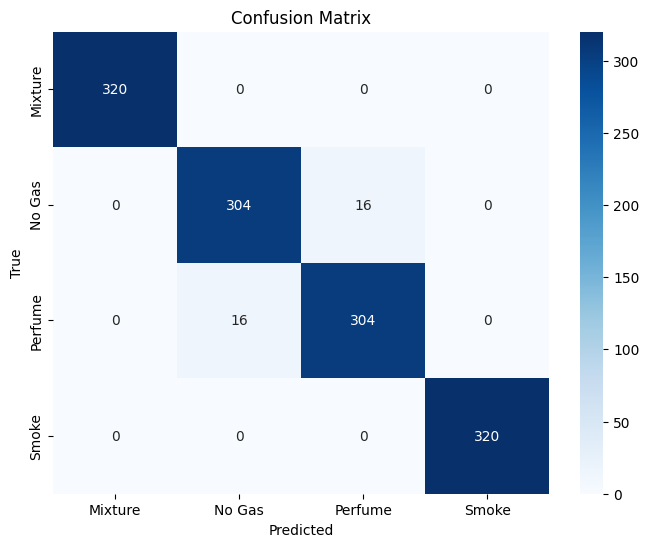

In [ ]:
conf_matrix = confusion_matrix((y_test_encode.idxmax(axis=1)).apply(lambda row: classes[row]), np.argmax(meta_preds, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(labels.values()),
            yticklabels=list(labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# MUltiModal

## With CNN

In [ ]:
!unzip ./zkwgkjkjn9-2/Thermal\ Camera\ Images/Mixture.zip -d Mixture
!unzip ./zkwgkjkjn9-2/Thermal\ Camera\ Images/NoGas.zip -d NoGas
!unzip ./zkwgkjkjn9-2/Thermal\ Camera\ Images/Perfume.zip -d Perfume
!unzip ./zkwgkjkjn9-2/Thermal\ Camera\ Images/Smoke.zip -d Smoke

Streaming output truncated to the last 5000 lines.
 extracting: Mixture/823_Mixture.png  
 extracting: Mixture/824_Mixture.png  
 extracting: Mixture/825_Mixture.png  
 extracting: Mixture/826_Mixture.png  
 extracting: Mixture/827_Mixture.png  
 extracting: Mixture/828_Mixture.png  
 extracting: Mixture/829_Mixture.png  
 extracting: Mixture/82_Mixture.png  
 extracting: Mixture/830_Mixture.png  
 extracting: Mixture/831_Mixture.png  
 extracting: Mixture/832_Mixture.png  
 extracting: Mixture/833_Mixture.png  
 extracting: Mixture/834_Mixture.png  
 extracting: Mixture/835_Mixture.png  
 extracting: Mixture/836_Mixture.png  
 extracting: Mixture/837_Mixture.png  
 extracting: Mixture/838_Mixture.png  
 extracting: Mixture/839_Mixture.png  
 extracting: Mixture/83_Mixture.png  
 extracting: Mixture/840_Mixture.png  
 extracting: Mixture/841_Mixture.png  
 extracting: Mixture/842_Mixture.png  
 extracting: Mixture/843_Mixture.png  
 extracting: Mixture/844_Mixture.png  
 extracting: Mi

In [ ]:
dataset = 'zkwgkjkjn9-2/Gas Sensors Measurements/Gas_Sensors_Measurements.csv'
df = pd.read_csv(dataset)

X_num = df.drop(['Serial Number', 'Gas', 'Corresponding Image Name'], axis=1)

y = df['Gas']

X_img = pd.DataFrame()

X_img['ImagePath'] = './' + df['Gas'] + '/' + df['Corresponding Image Name'] + '.png'

numerical_train, numerical_test, image_train, image_test, labels_train, labels_test = train_test_split(
    X_num.values, X_img.values, y, test_size=0.2, random_state=42)

In [ ]:
labels_train_encode = pd.get_dummies(labels_train)
print(labels_train_encode.shape)

labels_test_encode = pd.get_dummies(labels_test)
labels_test_encode.shape

(5120, 4)


(1280, 4)

In [ ]:
numerical_train.shape, image_train.shape, labels_train.shape

((5120, 7), (5120, 1), (5120,))

In [ ]:
img = Image.open(image_train[10][0])
np.array(img).shape

(640, 480, 3)

In [ ]:
height, width, channel = 640, 480, 3

In [ ]:
def read_and_normalize_images(file_paths):
    images = []
    for path in file_paths:
        img = Image.open(path[0])

        img = img.resize((width, height))

        img = np.array(img)
        normalized_img = img.astype(np.float32) / 255.0

        images.append(normalized_img)
    return np.array(images)

In [ ]:
input_image = Input(shape=(height, width, channel))
conv1 = Conv2D(64, kernel_size=3, activation='relu')(input_image)
pool1 = MaxPooling2D(pool_size=2)(conv1)
conv2 = Conv2D(32, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=2)(conv2)

flatten = Flatten()(pool2)
image_output = Dense(128, activation='relu')(flatten)

cnn_model = Model(inputs=input_image, outputs=image_output)


input_numerical = Input(shape=(numerical_train.shape[1]))
l1 = Dense(64, activation='relu')(input_numerical)
l2 = Dense(32, activation='relu')(l1)
numerical_output = Dense(16, activation='relu')(l2)

numerical_model = Model(inputs=input_numerical, outputs=numerical_output)

concatenated = concatenate([image_output, numerical_output])
fusion_output = Dense(32, activation='relu')(concatenated)
final_output = Dense(4, activation='softmax')(fusion_output)

multimodal_model = Model(inputs=[input_image, input_numerical], outputs=final_output)


multimodal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
multimodal_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 480, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 638, 478, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 319, 239, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 317, 237, 32)         18464     ['max_pooling2d[0][0]'] 

In [ ]:
epoch = 1
batch = 30
for j in range(epoch):
  print('\n****************************\n')
  print('epoch:', j+1)
  print('\n****************************\n')
  for i in range(0, len(image_train), batch):
    print(i/len(image_train))
    num_train = numerical_train[i : i+batch]
    img_train = read_and_normalize_images(image_train[i : i+batch])
    lab_train = labels_train_encode[i : i+batch]
    try:
      multimodal_model.fit([img_train, num_train], lab_train, epochs=1, batch_size=len(num_train), validation_split=0.2)
    except:
      pass


****************************

epoch: 1

****************************

0.0
1/1 [==============================] - 17s 17s/step - loss: 38.5815 - accuracy: 0.2083 - val_loss: 43.1129 - val_accuracy: 0.3333
0.005859375
1/1 [==============================] - 1s 619ms/step - loss: 54.2743 - accuracy: 0.2500 - val_loss: 39.4802 - val_accuracy: 0.3333
0.01171875
1/1 [==============================] - 1s 535ms/step - loss: 54.8505 - accuracy: 0.1667 - val_loss: 37.0474 - val_accuracy: 0.3333
0.017578125
1/1 [==============================] - 1s 521ms/step - loss: 43.5239 - accuracy: 0.2083 - val_loss: 18.4516 - val_accuracy: 0.3333
0.0234375
1/1 [==============================] - 1s 504ms/step - loss: 18.3488 - accuracy: 0.3333 - val_loss: 6.1363 - val_accuracy: 0.3333
0.029296875
1/1 [==============================] - 1s 528ms/step - loss: 3.9634 - accuracy: 0.5417 - val_loss: 8.4824 - val_accuracy: 0.5000
0.03515625
1/1 [==============================] - 1s 506ms/step - loss: 9.4140 - accur

In [ ]:
loss, accuracy = multimodal_model.evaluate([read_and_normalize_images(image_test[:50]), numerical_test[:50]], labels_test_encode[:50])
print(f"Test Accuracy: {accuracy * 100:.2f}%")

2/2 [==============================] - 3s 961ms/step - loss: 0.2829 - accuracy: 0.8800
Test Accuracy: 88.00%
